In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mplfinance as mpf
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [30]:
# Identify missing days 
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_days = all_days.difference(data.index)

missing_days_df = pd.DataFrame(missing_days, columns=['MissingDate'])
missing_days_df['DayOfWeek'] = missing_days_df['MissingDate'].dt.day_name()

print("Missing days with day of the week:")
print(missing_days_df)

pattern_analysis = missing_days_df['DayOfWeek'].value_counts()
print("\nPattern of missing days by day of the week:")
print(pattern_analysis)

Missing days with day of the week:
     MissingDate DayOfWeek
0     2006-01-07  Saturday
1     2006-01-08    Sunday
2     2006-01-14  Saturday
3     2006-01-15    Sunday
4     2006-01-16    Monday
...          ...       ...
1354  2017-12-16  Saturday
1355  2017-12-17    Sunday
1356  2017-12-23  Saturday
1357  2017-12-24    Sunday
1358  2017-12-25    Monday

[1359 rows x 2 columns]

Pattern of missing days by day of the week:
DayOfWeek
Saturday     625
Sunday       625
Monday        59
Friday        21
Thursday      17
Tuesday        8
Wednesday      4
Name: count, dtype: int64


In [31]:
# NaN values
data[data.isna().any(axis=1)]

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-07-31,NaN,144.93,NaN,144.67,4355718,IBM


In [32]:
# cleanup
data = data.dropna()

# Visualization

In [33]:
# helper to work on selected dates only
def filter_data_by_date(data, df_callback):
    # Convert the index to integer positions for slider values
    date_range = data.index

    # Define a range slider for selecting the start and end indices
    range_slider = widgets.IntRangeSlider(
        value=[0, len(date_range) - 1],
        min=0,
        max=len(date_range) - 1,
        step=1,
        description='Date Range',
        continuous_update=False
    )

    # Display the slider widget
    display(range_slider)

    # Display the actual date range selected for clarity
    date_display = widgets.Label(
        value=f"Selected Range: {date_range[range_slider.value[0]].strftime('%d-%m-%Y')} to {date_range[range_slider.value[1]].strftime('%d-%m-%Y')}"
    )
    display(date_display)

    # Update the date display when the slider value changes
    def update_date_display(*args):
        date_display.value = f"Selected Range: {date_range[range_slider.value[0]].strftime('%d-%m-%Y')} to {date_range[range_slider.value[1]].strftime('%d-%m-%Y')}"
        start_idx, end_idx = range_slider.value
        filtered_df = data.iloc[start_idx:end_idx + 1]
        clear_output(wait=True)
        display(range_slider, date_display)
        df_callback(filtered_df.copy())

    range_slider.observe(update_date_display, 'value')

In [ ]:
# candlesticks and volume

def candlesticks(data):
    # Create a candlestick chart
    fig = go.Figure(data=[go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Candlestick'
    )])

    # Add volume as a bar chart on a secondary y-axis
    fig.add_trace(go.Bar(
        x=data.index,
        y=data['Volume'],
        name='Volume',
        marker=dict(color='rgba(128, 128, 128, 0.5)'),
        yaxis="y2"
    ))

    # Update layout to include a secondary y-axis for volume
    fig.update_layout(
        title="IBM Stock Candlestick Chart with Volume",
        xaxis_title="Date",
        yaxis_title="Price",
        yaxis2=dict(
            title="Volume",
            overlaying="y",
            side="right"
        ),
        xaxis_rangeslider_visible=False  # Hide the default range slider
    )

    # Show the figure
    fig.show()

filter_data_by_date(data, candlesticks)

IntRangeSlider(value=(0, 3018), continuous_update=False, description='Date Range', max=3018)

Label(value='Selected Range: 03-01-2006 to 29-12-2017')

# Observations from data

- no obvious patterns (who would have known)
- huge drop 20 oct 2014: https://www.wired.com/2014/10/ibm-globalfoundries/
- abnormal situations often associated with high trade volume

In [35]:
def find_optimal_period(data, min_period=1, max_period=1000):
    mse_values = []
    periods = range(min_period, max_period + 1)

    for period in periods:
        decomposition = seasonal_decompose(data['Close'], model='additive', period=period)
        residuals = decomposition.resid
        mse = np.nanmean(residuals ** 2)  # Calculate MSE, ignoring NaN values
        mse_values.append((period, mse))

    # Find the period with the minimum MSE
    best_period = min(mse_values, key=lambda x: x[1])[0]
    print("Best-fitting period:", best_period)

    return best_period, mse_values

# Example usage
best_period, mse_values = find_optimal_period(data)


Best-fitting period: 1


In [36]:
def plot_decomposition(period):
    decomposition = seasonal_decompose(data['Close'], model='additive', period=period)
    plt.figure(figsize=(14, 10))
    decomposition.plot()
    plt.suptitle('Time Series Decomposition of IBM Closing Prices', y=1.05)
    plt.show()

# Create an interactive slider for period (min, max, step)
interact(plot_decomposition, period=widgets.IntSlider(min=1, max=1000, step=1, value=200))


interactive(children=(IntSlider(value=200, description='period', max=1000, min=1), Output()), _dom_classes=('w…

<function __main__.plot_decomposition(period)>

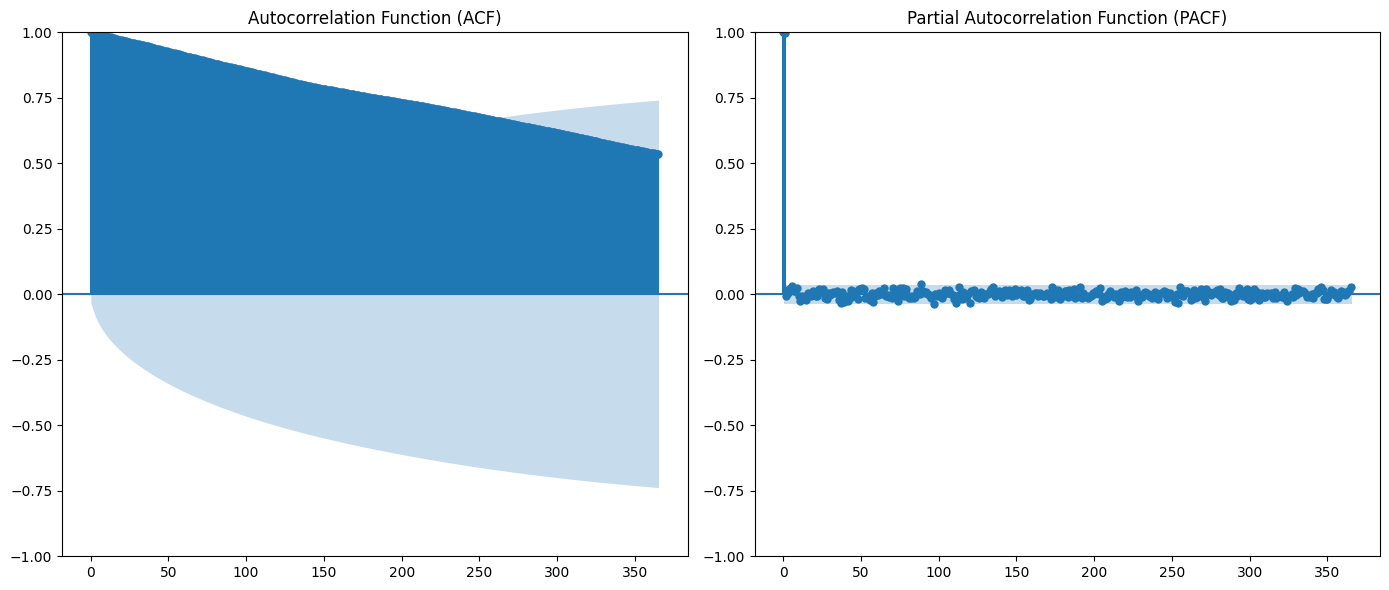

In [37]:
# 3. Autocorrelation Analysis
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(data['Close'], lags=365, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(1, 2, 2)
plot_pacf(data['Close'], lags=365, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
